<a href="https://colab.research.google.com/github/GregSym/Numberphile_Follow_Alongs/blob/spoon/NumberphileFollowAlongs_StonesOnAnInfiniteChessboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stones on an Infinite Chessboard
https://www.youtube.com/watch?v=m4Uth-EaTZ8

A game in which a set of starting stones of value one are placed on a theoretically infinite grid in order to generate the largest possible sequence of natural numbers by evaluating the sum of a cell in the aforementioned grid's cells.

I suppose part of the challenge here is visualising that so it's not as confusing as I made it sound. The YT video is much easier to follow.

In [3]:
from __future__ import annotations
import collections
import numpy as np

## Principle setup for running the game

In [4]:
board: collections.defaultdict[tuple[int, int], int] = collections.defaultdict(lambda: 0)

In [5]:
def setup_init_state(board: collections.defaultdict[int], init_stones=2):
  if init_stones==2:
    board[(0, 0)] = 1
    board[(2, 2)] = 1

adjacency = ((-1, -1), (0, -1), (1, -1), (-1, 0), (0, 0), (1, 0), (0, 1), (1, 1))
assert len(set(adjacency)) == 8  # check for 8 unique elements because i screw these up a lot

def play_game(board: collections.defaultdict[tuple[int, int], int]):
  max_x = max(k[0] for k in board)
  max_y = max(k[1] for k in board)
  for x in range(max_x+1):
    for y in range(max_y+1):
      adj_sum = sum(board[(x+dx, y+dy)] for (dx,dy) in adjacency)
      if adj_sum not in board.values() and adj_sum == max(board.values()) + 1 and board[(x, y)] == 0:
        board[(x, y)] = adj_sum

def board_to_data(board: collections.defaultdict[tuple[int, int], int]) -> list[list[int]]:
  if any((x<0 or y<0) for x, y in board):
    diagonal_shift = collections.defaultdict(lambda: 0)
    diagonal_shift.update({(x-min(x for x,y in board), y-min(y for x,y in board)): value for (x,y), value in board.items()})
    board = diagonal_shift
  max_x = max(k[0] for k in board)
  max_y = max(k[1] for k in board)
  data = np.zeros((max_x+1, max_y+1))
  for (x, y), value in board.items():
    data[y, x] = value
  return data

In [6]:
setup_init_state(board=board)
play_game(board=board)
print(board_to_data(board=board))
play_game(board=board)
print(board_to_data(board=board))

[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 3. 1. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 3. 1. 0. 0.]
 [0. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


## Packaging some of this functionality

In [51]:
class NumbersAndStones:
  """ Useful namespace for containing the game and its board """
  def __init__(self, initial_state: int = 2):
    self.initial_state = initial_state
    self.paths = [set()]
    self.one_layer_blacklist: set[tuple[int, int]] = set()
    self.setup()

  def setup(self):
    self.board: collections.defaultdict[tuple[int, int], int] = collections.defaultdict(lambda: 0)
    self.last_state: collections.defaultdict[tuple[int, int], int] = collections.defaultdict(lambda: 0)
    setup_init_state(board=self.board, init_stones=self.initial_state)
    self.last_state.update(self.board)
    self.sequence: set[int] = set()
  
  def play_game(self):
    self.last_state = collections.defaultdict(lambda: 0)
    self.last_state.update(self.board)
    max_x = max(x for (x,y) in self.board)
    max_y = max(y for (x,y) in self.board)
    for x in range(max_x+1):
      for y in range(max_y+1):
        adj_sum = sum(self.board[(x+dx, y+dy)] for (dx,dy) in adjacency)
        if (
            adj_sum not in self.board.values() 
            and adj_sum == max(self.board.values()) + 1 
            and self.board[(x, y)] == 0 and all(((x,y) != b) for b in self.one_layer_blacklist)
            ):
          print(adj_sum)
          self.board[(x, y)] = adj_sum
  
  def evaluate_growth(self) -> bool:
    """ 
    return whether or not growth stagnated (mathematically this <i>must</i> happen)
    irrespective of init state
    True: growth
    False: stagnated
    """
    return not self.sequence == set({*self.last_state.values()})
  
  def play_sequence(self):
    self.play_game()
    while self.evaluate_growth():
      self.one_layer_blacklist = set()  # reset
      self.play_game()
      self.sequence.update({*self.board.values()})
    
    failed_placement, = [indeces for indeces, v in self.board.items() if v==max(self.board.values())]
    self.one_layer_blacklist.add(failed_placement)
    print(self.one_layer_blacklist)
    self.board.pop(failed_placement)
    if max(self.sequence) < 6:
      self.play_sequence()
    self.paths[0].update({i for i,v in self.board.items() if v>1})
  
  @property
  def ndarray(self):
    return board_to_data(board=self.board)

In [52]:
game = NumbersAndStones()
game.play_sequence()
print(game.ndarray)
print(game.sequence)
print(game.paths)

2
3
4
{(1, 3)}
4
5
6
{(0, 1)}
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{0, 1, 2, 3, 4, 5, 6}
[{(1, 2), (3, 3), (2, 3), (1, 1)}]


## Should probably test some fundamentals

In [53]:
def test_natural_numbers(pattern: NumbersAndStones):
  for el, next_el in zip(pattern.sequence, list(pattern.sequence)[1:]):
    assert el + 1 == next_el

test_natural_numbers(game)

## But can it look more interesting than an NDArray?

2
3
4
{(1, 3)}
4
5
6
{(0, 1)}


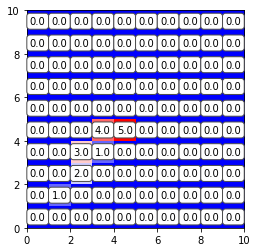

In [54]:
import matplotlib.pyplot as plt
import sys
if float(f"{sys.version_info[0]}.{sys.version_info[1]}") < 3.8:
  from typing_extensions import Protocol  # < 3.8 Protocol lives in a different package
else:
  from typing import Protocol

class _VisualiserInterfaceCheckerboardCounting(Protocol):
  """ Interface for visualisation in this notebook """
  def __call__(self, pattern: NumbersAndStones, verbose: bool) -> None:
      ...

def visualise_checkerboard_counting(pattern: NumbersAndStones, verbose: bool = False):
  """ (pattern) -> visualisation of checkerboard counting game """
  # src: https://stackoverflow.com/questions/36668160/graphing-a-colored-grid-in-python
  # thanccs == asker: fosho, answerer: Suever
  # Just some example data (random)
  data = pattern.ndarray  # change this line to control colour map

  rows,cols = data.shape
  plt.imshow(data[::-1,::], interpolation='nearest', 
                  extent=[0, 0+cols, 0, 0+rows],  # offset should be zero
                  cmap='bwr')  # controls colour scheme
  # write stone value to the heat map
  for (y,x), stone in np.ndenumerate(data):
    plt.text(x+.5, y+.5, str(stone), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
  # plt.axes()
  plt.axis('scaled')
  plt.show()

# run it
game = NumbersAndStones()
game.play_sequence()
visualise_checkerboard_counting(pattern=game)